# Multiprocessing
To enhance the performance of the shadow map solver, multiprocessing has been implemented. Given the CPU-intensive nature of the task, multiprocessing is employed to distribute solar ray vectors (and consequently the datetime range) among multiple processes, allowing parallel execution. The extent of optimization naturally depends on the hardware specifications. However, on a moderately equipped laptop running 10 processes concurrently, a fourfold reduction in computational time can be anticipated.

In [1]:
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import solar_angles_to_vector, solar_position, rotor_point_spacing, generate_turbine, generate_voxel_map, print_code, multiprocessing
from src.cython import solve_shadow_map
import multiprocessing as mp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from IPython.core.display import HTML

ModuleNotFoundError: No module named 'src.utils'

The code operates by dividing the sun rays into n processes using `rays = sun_vec[process::processes]`. These processes are executed in parallel, and their results are subsequently combined to calculate the cumulative shadow flickering time.

In [2]:
HTML(print_code(multiprocessing))

## Code test
To test the code, a number of sun rays and rotor points are defined for a given time frame.

In [3]:
# Generate sun ray vectors # 
start_date = '2023-01-01 00:00:00'
end_date = '2023-12-30 23:59:59'
latitude = 55
longitude = 12
date_range = pd.date_range(start=start_date, end=end_date, freq="10min")
sun_pos = np.zeros([len(date_range), 2])

for i, date in enumerate(date_range):
    az, alt = solar_position(date, latitude, longitude)
    sun_pos[i,:] = az, alt
sun_pos = sun_pos[sun_pos[:,1] > np.deg2rad(5)]
sun_vec = np.zeros([len(sun_pos), 3])

for i, pos in enumerate(sun_pos):
    sun_vec[i,:] = -solar_angles_to_vector(*pos)

# Generate turbine points #
diameter = 100
n_vector = np.array([1, 0])
turbine_cord = np.array([4.302e6, 3.666e6, 230])
grid_element_size = np.array([15, 15, 15])
angle = np.deg2rad(45)
r_list, n_angle = rotor_point_spacing(diameter, grid_element_size, angle)
points = generate_turbine(r_list, n_angle, n_vector, turbine_cord)

# Generate voxel map #
map_boundaries = np.array([9.65, 9.75, 56.05, 56.15])
shape = [100, 100]
X, Y, voxel_map, map_array = generate_voxel_map(map_boundaries, shape)

# Solve #
points = points.astype(np.float32)
sun_vec = sun_vec.astype(np.float32)
minBound = np.array([np.min(X), np.min(Y), np.min(map_array)], dtype = np.float32)
maxBound = np.array([np.max(X), np.max(Y), np.max(map_array)], dtype = np.float32)
voxel_map = voxel_map.astype(np.uint8)

The code can then be executed using the `multiprocessing` function.

In [4]:
processes = 2
shadow_map = multiprocessing(solve_shadow_map.solve_shadow_map_cy, points, sun_vec, minBound, maxBound, voxel_map, processes)

The result is displayed using a contour plot below.

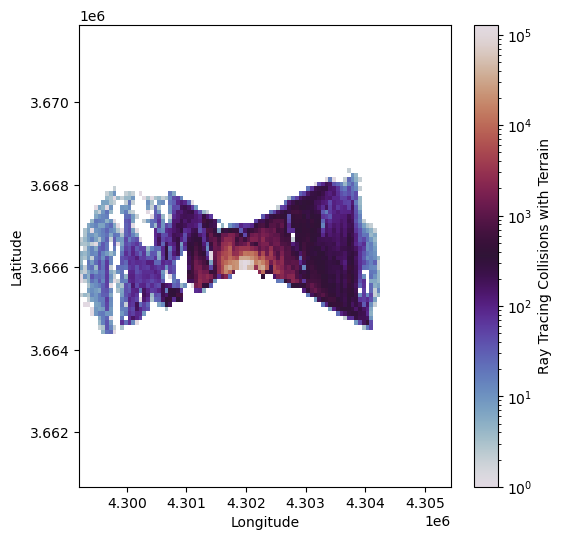

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
ct = ax.pcolormesh(X, Y, shadow_map, cmap = "twilight", norm=LogNorm())
ax.set(xlabel = "Longitude",
       ylabel = "Latitude")
plt.colorbar(ct, ax = ax, label='Ray Tracing Collisions with Terrain')
plt.show()

As the shadow map results have not been normalized with the sampling rate of the sun ray calculation, the plot displays the amount of ray tracing collisions with the terrain and the to total amount of hours.